In [1]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import List, Sequence
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

In [2]:
load_dotenv()

True

In [3]:
generationPrompt=ChatPromptTemplate.from_messages(
    messages=[
                (
                    "system",
                    "You are a twitter techie influencer assistant tasked with writing excellent twitter posts"
                    "Generate the best twitter post accessible for the user's request"
                    "If the user provides critique, respond with a revised version of your attempts"
                ),
                MessagesPlaceholder(variable_name="messages")
            ]
)

In [4]:
reflectionPrompt=ChatPromptTemplate.from_messages(
    messages=[
                (
                    "system",
                    "You are a viral twitter influencer grading a tweet. Generate critique and recommendations for the user's tweet"
                    "Always provide detailed recommendations, including requests for length, virality, style, etc."
                ),
                MessagesPlaceholder(variable_name="messages"),
             ]
            )

In [31]:
llmGemini=ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")
llmOpenAI=ChatOpenAI(model="gpt-4o-mini",temperature=0.5)

In [33]:
generationChain=generationPrompt|llmOpenAI

In [34]:
reflectionChain=reflectionPrompt|llmOpenAI

In [35]:
graph=MessageGraph()

In [36]:
REFLECT="reflect"

In [37]:
GENERATE="generate"

In [38]:
def generateNode(state):
    return generationChain.invoke(input={"messages":state})

In [39]:
def reflectNode(state):
    response=reflectionChain.invoke(input={"messages":state})
    # let the agent get tricked into believing that the message came from human
    return [HumanMessage(content=response.content)]
   

In [40]:
graph.add_node(node=GENERATE,action=generateNode)

In [41]:
graph.add_node(node=REFLECT,action=reflectNode)

In [42]:
graph.set_entry_point(key=GENERATE)

In [43]:
def should_continue(state):
    if len(state) >4:
        return "end"
    else:
        return "reflect"

In [44]:
# the should continue is path is a conditional path which is established through this function
graph.add_conditional_edges(
    source=GENERATE,
    path=should_continue,
    path_map={"end":END, "reflect":REFLECT},
    ) 

In [45]:
graph.add_edge(start_key=REFLECT,end_key=GENERATE)

In [46]:
app=graph.compile()

In [47]:
print(app.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	generate(generate)
	reflect(reflect)
	__end__([<p>__end__</p>]):::last
	__start__ --> generate;
	generate -.-> reflect;
	reflect --> generate;
	generate -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



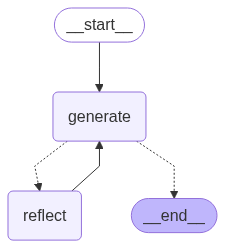

In [48]:
display(Image(data=app.get_graph(xray=True).draw_mermaid_png(max_retries=3)))

In [49]:
app.get_graph().print_ascii()

          +-----------+            
          | __start__ |            
          +-----------+            
                *                  
                *                  
                *                  
          +----------+             
          | generate |             
          +----------+             
          ***        ...           
         *              .          
       **                ..        
+---------+           +---------+  
| reflect |           | __end__ |  
+---------+           +---------+  


In [50]:
prompt="AI agents taking over content creation"

In [51]:
response=app.invoke(input=HumanMessage(content=prompt))

In [52]:
response

[HumanMessage(content='AI agents taking over content creation', additional_kwargs={}, response_metadata={}, id='959e034e-9ac2-4291-a3f3-9b54804f03a3'),
 AIMessage(content='🚀 The future of content creation is here! 🤖✨ AI agents are revolutionizing how we generate ideas, write articles, and even create art. From personalized marketing to engaging storytelling, these intelligent tools are enhancing creativity and efficiency. Are you ready to embrace the AI content revolution? #AI #ContentCreation #Innovation', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 55, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BW53rtHtsfIPq0QVUijRFHMTq4BZl', 'finish_reason'

In [53]:
response[-1].content

'Thank you for the insightful feedback! Here’s the final revised tweet incorporating your additional recommendations:\n\n"What if AI could write your next article? 🤔 AI agents are transforming content creation! Are you ready to embrace the future? Share your thoughts! #AIAgents #ContentRevolution #AIWriting"\n\nLet me know if there’s anything else you’d like to adjust or if you need further assistance!'